# Importing libraries 
 import of all necessary libraries

In [ ]:
import os 
import nltk
nltk.download("punkt")
#nltk.download('wordnet')
#nltk.download("stopwords")

#from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize , sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, f1_score

import numpy as np
import pandas as pd
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive 
drive.mount('gdrive')

Mounted at gdrive


In [ ]:
df = pd.read_csv("gdrive/My Drive/Colab Notebooks/augmented_datafile.csv")
df.drop(["Unnamed: 0"],axis=1,inplace=True)

old_df = pd.read_csv("gdrive/My Drive/Colab Notebooks/new_datafile.csv")
old_df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.head()

,Categories,Titles,Texts,Keywords
0,Animals,animal attack,animal attacks are violent often fatal attacks...,violent bites aggressive attack public...
1,Animals,animal coloration,animal coloration is the general appearance of...,appearance coloured camouflage incidenta...
2,Animals,animal ethics,animal ethics is branch of ethics which examin...,rights welfare law human animal cognit...
3,Animals,animal husbandry,animal husbandry is the branch of agriculture ...,agriculture day to day care selective bree...
4,Animals,animal law,animal law is combination of statutory and cas...,statutory law rights violates policies...


# Data preparation 
1. Text extraction from '.txt' files.
2. Creat the Dataframe.





In [ ]:
Categories = os.listdir("Base-wikipédia")
print("All text categories:\n\n\033[95m",Categories,"\033[0m \n \nNumber of categories :",len(Categories)) 

All text categories:

 ['Animals', 'Artificial Intelligence', 'Buildings', 'Communication and languages', 'Coronavirus', 'Elections', 'engeneering', 'Family', 'Health and fitness', 'Machines', 'Marketing', 'Means of transports', 'medicine', 'Music', 'nations of the world', 'Natural disasters', 'Planets', 'Programming languages', 'Relationships', 'Revolutions', 'Robotics', 'School', 'science fiction', 'Social-Média', 'Sports', 'Telecommunication', 'Tunisia', 'Video games', 'Wars', 'Web technologies']  
 
Number of categories : 30


In [ ]:
def data_preparation(Categories=Categories):
    """
    Categories : List of categories (and directory names)
    """
    texts = dict()
    for dir in Categories :
        titles = os.listdir("Base-wikipédia/"+dir)
        values = []
        for title in titles : 
            text = open("Base-wikipédia/"+dir+"/"+title,'r',encoding='Latin1')
            title = dir+"/"+title.replace('.txt',"")
            texts[title] = text.read()
            text.close()
    categories = [key.split('/')[0] for key in texts.keys()]
    titles = [key.split('/')[1] for key in texts.keys()]
    texts = list(texts.values())
    return categories,titles,texts

categories,titles,texts = data_preparation()

In [ ]:
# Creat a DataFrame containing all our data
df = pd.DataFrame({"Categories":categories,"Titles":titles, "Texts":texts})
df.head()

,Categories,Titles,Texts
0,Animals,Animal attack,"Animal attacks are violent, often fatal attack..."
1,Animals,Animal coloration,Animal coloration is the general appearance of...
2,Animals,Animal ethics,Animal ethics is a branch of ethics which exam...
3,Animals,Animal husbandry,Animal husbandry is the branch of agriculture ...
4,Animals,animal law,Animal law is a combination of statutory and c...


In [ ]:
# From line 449, we discover that the text column is absent and that it has been replaced by the title, the title by the keywords and the keywords by Nan.

df2 = pd.read_excel("résultats-wikipédia.xlsx")
df2.tail(151)

,Text,Title,etiquettes_finales
448,Telegraphy is the long-distance transmission o...,telegraphy,"['long-distance','transmission','textual messa..."
449,animal testing on non human primates,"['toxicity','medical','disease','pain','suffer...",NaN
450,animal testing on rodents,"['vertebrate species','mice','rats','reported'...",NaN
451,Mouse models of breast cancer metastasis,"['genetic','manipulation','mammary tumor','mut...",NaN
452,animal testing on invertebrates,"['anatomy','study','legislation','genetics','g...",NaN
...,...,...,...
594,stories,"['user','story','status','messages','informati...",NaN
595,Viber social media,"['application','operated','rakuten','android',...",NaN
596,use of social media by the islamic state of ir...,"['group','describe','forms','focus','social','...",NaN
597,timline of social media,"['commercially','marked','data','offers','soci...",NaN


In [ ]:
df["Keywords"] = "Keywords"

def keywords(df=df, df2=df2):
    """
    This function aims to put each list of keywords against it's text because the original file isn't well organized
    """
    keywords = pd.concat([ df2["etiquettes_finales"][:449] , df2["Title"][449:] ])
    titles = pd.concat([ df2["Title"][:449],df2["Text"][449:] ])
    titles = titles.apply(lambda x : x.lower().strip())
    
    for i in range(len(df["Keywords"])) :
        if df["Titles"][i].lower().strip() in list(titles) :
            
            title = df["Titles"][i].lower().strip()
            index = list(titles).index(title)      # get the index of the title from titles list 
            df["Keywords"][i] = keywords[index]
            
    return df

In [ ]:
# Call the function :
df_new = keywords()
df.head(2)

,Categories,Titles,Texts,Keywords
0,Animals,animal attack,animal attack violent often fatal attack cause...,"['violent','bites','aggressive','attack','publ..."
1,Animals,animal coloration,animal coloration general appearance animal re...,"['appearance','coloured','camouflage','inciden..."


In [ ]:
df_new[df_new["Keywords"]=="Keywords"] # 58 texts without

# Text pre-processing 
1.  Text cleaning (removal of punctuation, extraction of the stem of each word, removal of stop words).

In [ ]:
def text_cleaning(text):
    """
    text: text is string type to be cleaned.
    Function aims to clean the text from punctuation or special character, remove the stop words and lemmatizing the words.
   """

    lemmatizer = WordNetLemmatizer()
    text = text.lower()     # or df["Text"].str.lower()
    # eliminate any character that isn't an alphabet like punctuation and numbers ect...
    text = re.sub("[^a-zA-Z]"," ",text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english')) and len(word)>=2] 
    #words = [word for word in words if len(word)>=2] 

    return " ".join(words)

In [ ]:
# Text before cleaning: For any word with a length less of two, it will be removed.For example, the word U.S becomes meaningless after the "." is removed.
df["Texts"][0][:500] 

'Animal attacks are violent, often fatal attacks caused by animals against humans, one of the most common being bites. Bites are wounds caused as a result of an animal or human attack. \nThese attacks are a cause of human injuries and fatalities worldwide. According to the 2012 U.S. Pet Ownership & Demographics Sourcebook, 56% of United States citizens owned a pet. In the United States in 1994, approximately 4.7 million people were bitten by dogs. The frequency of animal attacks varies with geogra'

In [ ]:
# Text after cleaning:
text_cleaning(df["Texts"][0])[:500]

'animal attack violent often fatal attack caused animal human one common bite bite wound caused result animal human attack attack cause human injury fatality worldwide according pet ownership demographic sourcebook united state citizen owned pet united state approximately million people bitten dog frequency animal attack varies geographical location well hormonal secretion gonad gland found anterior side pituitary gland secrete androgen estrogen hormone animal high level hormone tend aggressive l'

In [ ]:
# Apply the "text_cleaning()" function on each text then save the new cleaned dataframe.
df["Titles"] = df["Titles"].apply(lambda x : x.lower().strip())
df["Cleaned Texts"] = df["Texts"].apply(lambda x : text_cleaning(x))

df.to_csv("gdrive/My Drive/Colab Notebooks/new_datafile.csv")

In [ ]:
df = pd.read_csv("gdrive/My Drive/Colab Notebooks/new_datafile.csv")
df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.head()   

,Categories,Titles,Texts,Keywords,Cleaned Texts
0,Animals,animal attack,animal attacks are violent often fatal attacks...,"['violent','bites','aggressive','attack','publ...",animal attack violent often fatal attack cause...
1,Animals,animal coloration,animal coloration is the general appearance of...,"['appearance','coloured','camouflage','inciden...",animal coloration general appearance animal re...
2,Animals,animal ethics,animal ethics is branch of ethics which examin...,"['rights','welfare','law','human-animal','cogn...",animal ethic branch ethic examines human anima...
3,Animals,animal husbandry,animal husbandry is the branch of agriculture ...,"['agriculture','day-to-day care','selective br...",animal husbandry branch agriculture concerned ...
4,Animals,animal law,animal law is combination of statutory and cas...,"['statutory','law','rights','violates','polici...",animal law combination statutory case law natu...


# Text Embeddings


In [ ]:
# Plotting the given similarity matrix.
def plot_similarity_matrix(data):
  fig, ax = plt.subplots(figsize=(10,10)) 
  ax = sns.heatmap(data,annot=True)
  ax.axes.set_title("Similarity matrix")
  plt.plot()

## Doc2Vec Embeddings 
1. Tagged data.
2. Train the model + Hyperparameter tuning.
3. Calculate the similarity between two sentences from different texts.

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
# Prepare the data for the model
def tagged_data():
  
  tokenized_sent = []
  for s in df["Texts"]:
    tokenized_sent.append(word_tokenize(s))
  for s in df["Titles"]:
    tokenized_sent.append(word_tokenize(s)) # not necessary because the title appears at the beginning of each paragraph
  #for s in df["Keywords"]:
    #tokenized_sent = tokenized_sent + s  
  
  tagged_dataa = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]
   
  return tagged_dataa

data_for_training = tagged_data()  

In [ ]:
# Initialize the model
modelDoc2Vec = Doc2Vec(vector_size = 100, window = 2, min_count = 2, epochs = 80)

modelDoc2Vec.build_vocab(data_for_training) 

In [ ]:
modelDoc2Vec.train(data_for_training, total_examples=modelDoc2Vec.corpus_count, epochs=modelDoc2Vec.epochs)

In [ ]:
modelDoc2Vec.save("doc2vec.model")

In [ ]:
modelDoc2Vec = Doc2Vec.load("gdrive/My Drive/Colab Notebooks/doc2vec.model")

In [ ]:
def Similarity_d2v(data=list(df["Texts"]),n=25,end=100,step=10):
  """ 
  data : Series or list of texts or sentences
  """
  embed, sentences = [], []
  # Selection of two texts from the first 10 categories
  for i in range(0,end,step):
    # Extract the first n words of each text
    L = data[i].split()
    embed.append(modelDoc2Vec.infer_vector(L[n]))
    sentences.append(" ".join(L[:n]))
  
  embed = np.array(embed)
  cos = cosine_similarity(embed,embed)
  return cos,sentences

S, sentences_d2v = Similarity_d2v()

In [ ]:
df_sim = pd.DataFrame(data=S, columns=sentences_d2v,index=sentences_d2v)
df_sim.head(1)

,animal attack violent often fatal attack caused animal human one common bite bite wound caused result animal human attack attack cause human injury fatality worldwide,animal welfare institute awi american non profit charitable organization founded christine stevens goal reducing suffering inflicted animal human one oldest animal welfare organization u legislative,ai box hypothetical isolated computer hardware system possibly dangerous artificial intelligence ai kept constrained virtual prison solution ai control problem allowed directly manipulate event external,artificial neural network ann connectionist system computing system vaguely inspired biological neural network constitute animal brain system learn perform task considering example generally without programmed,amphitheatre capua roman amphitheatre city capua modern santa maria capua vetere second colosseum size probably model may first amphitheatre built roman location first famous gladiator,campbelltown city located outskirt metropolitan area sydney new south wale australia located greater western sydney kilometre mi south west sydney central business district campbelltown administrative,body language type nonverbal communication physical behavior opposed word used express convey information behavior includes facial expression body posture gesture eye movement touch use space,language acquisition process human acquire capacity perceive comprehend language word gain ability aware language understand well produce use word sentence communicate language acquisition involves structure,coronavirus act act parliament united kingdom grant government emergency power handle covid pandemic act allows government discretionary power limit suspend public gathering detain individual suspected,effect covid infection pregnancy completely known lack reliable data increased risk pregnant woman fetus far readily detectable prediction based similar infection sars mers suggest pregnant
animal attack violent often fatal attack caused animal human one common bite bite wound caused result animal human attack attack cause human injury fatality worldwide,1.0,0.600612,0.688999,0.383223,0.678347,0.520741,0.440089,0.413357,0.772655,0.664658


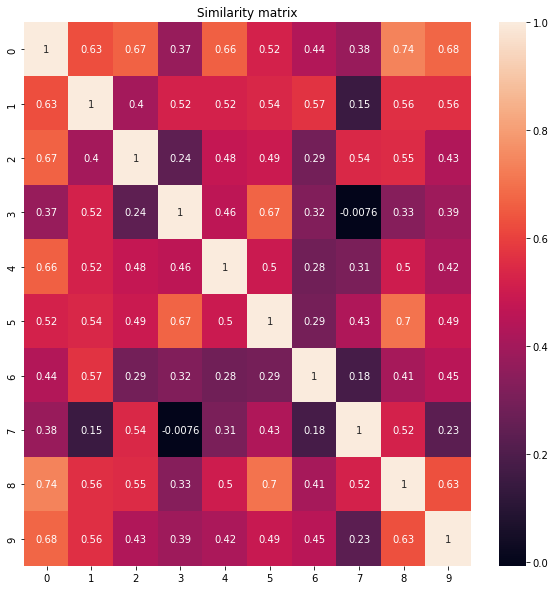

In [ ]:
# Plotting the similarity matrix "S"
plot_similarity_matrix(S)

In [ ]:
def Similarity_keywords_d2v(data=list(df["Keywords"]),end=100,step=10):
  """ 
  data : Series or list of texts or sentences
  """
  embed, keywords = [], []
  # Selection of two lists of keywords from the first 10 categories
  for i in range(0,end,step):
    keyword = re.sub("[^A-Za-z]"," ",data[i])
    keyword= keyword.strip()
    keywords.append( keyword)
    embed.append(modelDoc2Vec.infer_vector(data[i]))
  
  embed = np.array(embed)
  cos = cosine_similarity(embed,embed)
  return cos,keywords

Sk, keywords_d2v = Similarity_keywords_d2v()

In [ ]:
df_sim = pd.DataFrame(data=Sk, columns=keywords_d2v,index=keywords_d2v)
df_sim.head(2)

,violent bites aggressive attack public health predation hunt,organization reducing suffering inflicted on animals rights protection endangered species threatened,hardware system dangerous communication technologies computer,network function learning layer output,Roman ampheatre colosseum keystones museum,Elizabeth Campbell Tharawal Syndney metropolitan area british settlers camden,nonverbal communication behaviors express information,process acquire perceive comprehend language communicated use produce,act of the parliament emergency limit suspend public gathetings disease healthcare,infection fetuses predictions SARS MERS
violent bites aggressive attack public health predation hunt,1.000000,0.947711,0.938545,0.914934,0.907884,0.906551,0.936228,0.920448,0.944697,0.906760
organization reducing suffering inflicted on animals rights protection endangered species threatened,0.947711,1.000000,0.965176,0.902928,0.907927,0.886264,0.932876,0.938202,0.971710,0.936351


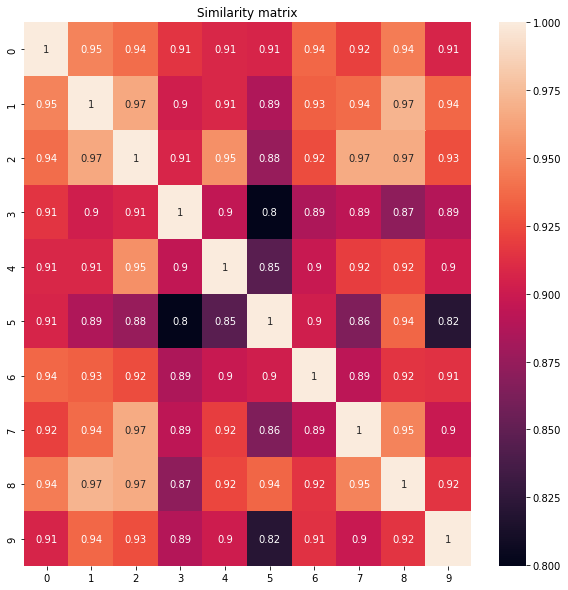

In [ ]:
# Plotting the similarity matrix "S"
plot_similarity_matrix(Sk)

 **Conclusion :**

Doc2Vec is not very accurate, he also made mistakes like **approaching** two contexts together when they are totally different, like talking about animals and artificial intelligence.

## Universal Sentence Encoder Embeddings

In [ ]:
import tensorflow_hub as hub
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def Similarity_use(data=list(df["Texts"]),end=100,step=10,n=25):
  sentences =  []
  # Selection of two texts from the first 10 categories
  for i in range(0,end,step):
    # Extract the first n words of each text
    L = data[i].split()
    sentences.append(" ".join(L[:n]))

  embeddings = use_model(sentences) 
  cosine_sim = cosine_similarity(embeddings, embeddings)
  
  return cosine_sim,sentences

Su, sentences_use = Similarity_use()

In [ ]:
df_sim = pd.DataFrame(data=Su, columns=sentences_use,index=sentences_use)
df_sim.head(1)

[]

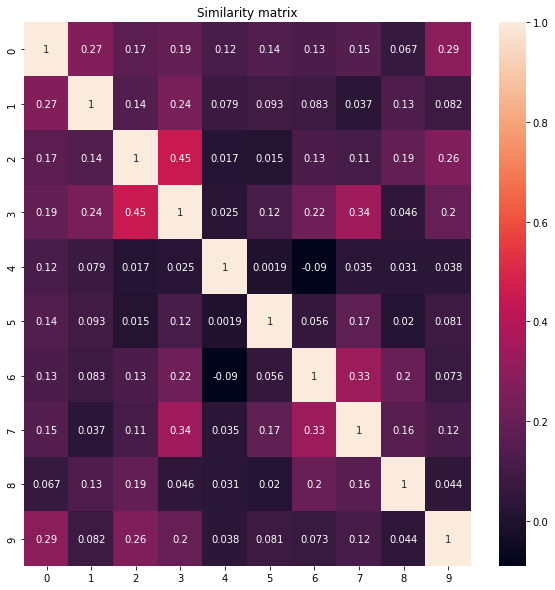

In [ ]:
# Plotting the similarity matrix 
plot_similarity_matrix(Su)

In [ ]:
def Similarity_keywords_use(data=list(df["Keywords"]),end=100,step=10):
  """ 
  data : Series or list of texts or sentences
  """
  keywords = []
  # Selection of two lists of keywords from the first 10 categories
  for i in range(0,end,step):
    keyword = re.sub("[^A-Za-z]"," ",data[i])
    keyword= keyword.strip()
    keywords.append( keyword) 
  
  embeddings = use_model(keywords) 
  cosine_sim = cosine_similarity(embeddings, embeddings)

  return cosine_sim,keywords

Sku, keywords_use = Similarity_keywords_use()

In [ ]:
df_sim = pd.DataFrame(data=Sku, columns=keywords_use,index=keywords_use)
df_sim.head(1)

[]

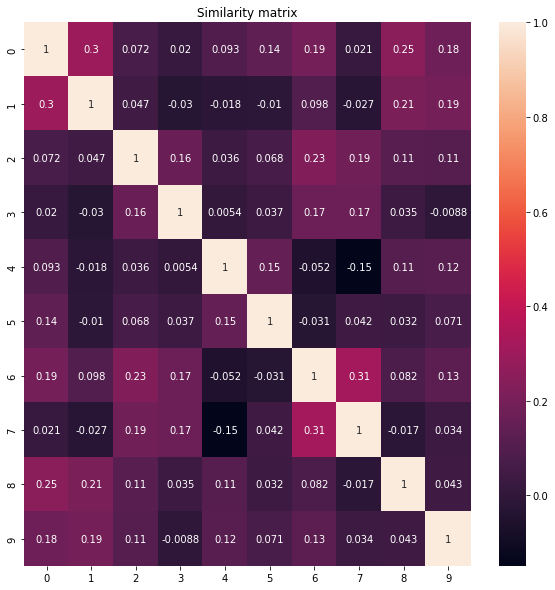

In [ ]:
# Plotting the similarity matrix 
plot_similarity_matrix(Sku)

## Sentence Bert model Embeddings

In [ ]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
def Similarity_bert(data=list(df["Texts"]),end=100,step=10,n=25):
  sentences =  []
  # Selection of two texts from the first 10 categories
  for i in range(0,end,step):
    # Extract the first n words of each text
    L = data[i].split()
    sentences.append(" ".join(L[:n]))

  embeddings = sbert_model.encode(sentences,convert_to_numpy=True) # Convert tensor type to numpy array
  cosine_sim = cosine_similarity(embeddings, embeddings)
  
  return cosine_sim,sentences

Sb, sentences_bert = Similarity_bert()

In [ ]:
df_sim = pd.DataFrame(data=Sb, columns=sentences_bert,index=sentences_bert)
df_sim.head(1)

,animal attack violent often fatal attack caused animal human one common bite bite wound caused result animal human attack attack cause human injury fatality worldwide,animal welfare institute awi american non profit charitable organization founded christine stevens goal reducing suffering inflicted animal human one oldest animal welfare organization u legislative,ai box hypothetical isolated computer hardware system possibly dangerous artificial intelligence ai kept constrained virtual prison solution ai control problem allowed directly manipulate event external,artificial neural network ann connectionist system computing system vaguely inspired biological neural network constitute animal brain system learn perform task considering example generally without programmed,amphitheatre capua roman amphitheatre city capua modern santa maria capua vetere second colosseum size probably model may first amphitheatre built roman location first famous gladiator,campbelltown city located outskirt metropolitan area sydney new south wale australia located greater western sydney kilometre mi south west sydney central business district campbelltown administrative,body language type nonverbal communication physical behavior opposed word used express convey information behavior includes facial expression body posture gesture eye movement touch use space,language acquisition process human acquire capacity perceive comprehend language word gain ability aware language understand well produce use word sentence communicate language acquisition involves structure,coronavirus act act parliament united kingdom grant government emergency power handle covid pandemic act allows government discretionary power limit suspend public gathering detain individual suspected,effect covid infection pregnancy completely known lack reliable data increased risk pregnant woman fetus far readily detectable prediction based similar infection sars mers suggest pregnant
animal attack violent often fatal attack caused animal human one common bite bite wound caused result animal human attack attack cause human injury fatality worldwide,1.0,0.345017,0.046534,0.15471,0.07912,0.088,0.20324,0.138563,0.251558,0.166452


[]

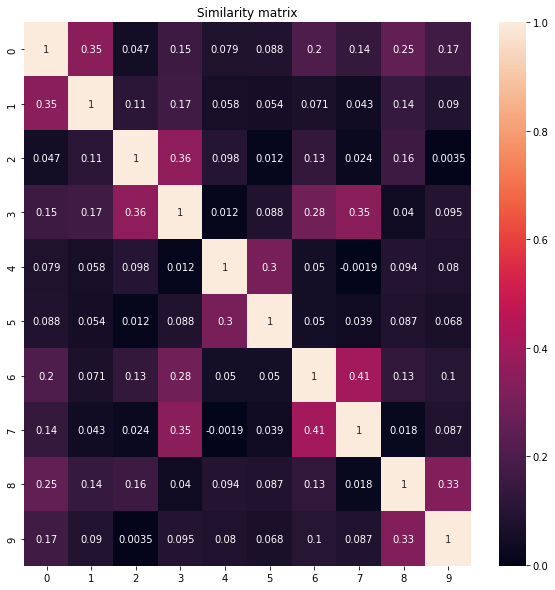

In [ ]:
# Plotting the similarity matrix "S"
plot_similarity_matrix(Sb)

In [ ]:
def Similarity_keywords_bert(data=list(df["Keywords"]),end=100,step=10):
  """ 
  data : Series or list of texts or sentences
  """
  keywords = []
  # Selection of two lists of keywords from the first 10 categories
  for i in range(0,end,step):
    keyword = re.sub("[^A-Za-z]"," ",data[i])
    keyword= keyword.strip()
    keywords.append( keyword) 
  
  embeddings = sbert_model.encode(keywords, convert_to_numpy=True) # convert tensor type to numpy array
  cosine_sim = cosine_similarity(embeddings, embeddings)


  return cosine_sim,keywords

Skb, keywords_bert = Similarity_keywords_bert()

In [ ]:
df_sim = pd.DataFrame(data=Skb, columns=keywords_bert,index=keywords_bert)
df_sim.head(1)

,violent bites aggressive attack public health predation hunt,organization reducing suffering inflicted on animals rights protection endangered species threatened,hardware system dangerous communication technologies computer,network function learning layer output,Roman ampheatre colosseum keystones museum,Elizabeth Campbell Tharawal Syndney metropolitan area british settlers camden,nonverbal communication behaviors express information,process acquire perceive comprehend language communicated use produce,act of the parliament emergency limit suspend public gathetings disease healthcare,infection fetuses predictions SARS MERS
violent bites aggressive attack public health predation hunt,1.0,0.484594,0.156321,-0.041221,-0.035853,0.032248,0.214555,0.067162,0.144616,0.126515


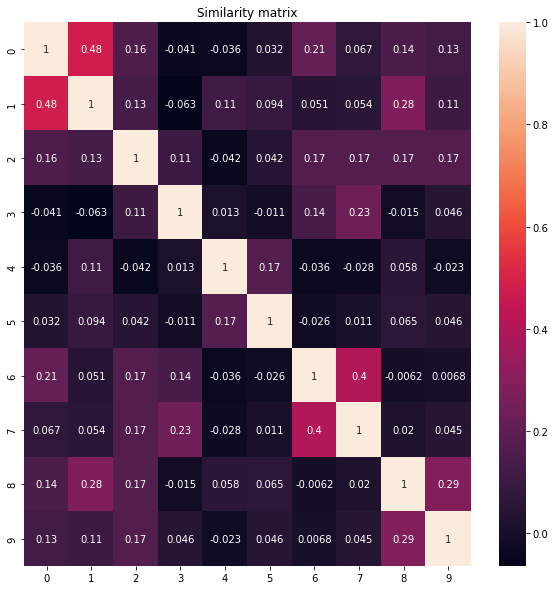

In [ ]:
# Plotting the similarity matrix "S"
plot_similarity_matrix(Skb)

# WordNet 

in order to achieve a high level of accuracy in comparing each list of keywords to the others, we will use the WordNet dictionary **`to eliminate synonyms`** and mesure the similarity between words that don't have a synonymous relationship.

In [ ]:
def word_synonyms(word):
   """
    word : a string (word) whose synonyms we will search.
   """
   synonyms = set()
   for synset in wordnet.synsets(word):
      for l in synset.lemmas():
          synonyms.add(l.name()) 

   return list(synonyms) # get just the unique words


list_syn = [word_synonyms(word) for word in ["good","bad"]]
list_syn

In [ ]:
word_synonyms("bitten") # The adjective bitten has the word bite as a synonym which is it's verbe

['seize_with_teeth', 'burn', 'sting', 'bite', 'prick']

In [ ]:
def search_synonyms(word,list_syn):
  """
  Input:
    word : a string
    list_syn : list of synonyms of a given word in which we will search if the "word" is a synonym of the given one.
  Output:
    index of the "word" in the list if it is found otherwise return False
  """
  for i in range(len(list_syn)):
    if word in list_syn[i]:
      return i
    else:
      return False

index = search_synonyms("full",list_syn)
index

0

In [ ]:
list_syn[0].index("full") # word "full" exists in the first list with the index 19

13

In [ ]:
def keywords_cosine_matrix(data=df["Keywords"]):

  key_i, key_j = [], []
  k = 0
  cosine_matrix = np.eye(len(data))

  for i in  range(len(data)):
    key_i = text_cleaning(data[i]).split()      # clean the list of keywords which is represented as an "str" type
    synonyms_i = [word_synonyms(word) for word in key_i ] # extract the synonyms of each word in the first list

    for j in range(len(data)):
      if j==i:
        continue
      else:
        key_j =  text_cleaning(data[j]).split()
        while k < len(key_j):
          if search_synonyms(key_j[k], synonyms_i) != False  :
            index = search_synonyms(key_j[k], synonyms_i)
            key_j.remove(key_j[k]) # remove the similar words
            print(index)
            key_i.remove(key_i[index]) # remove the main words after removing their synonyms
          
          k+=1

        embed = sbert_model.encode([" ".join(key_i), " ".join(key_j),], convert_to_numpy=True)
        cos = cosine_similarity(embed)[0][1]
        cosine_matrix[i,j] = cos
        

  return cosine_matrix

In [ ]:
matrix = keywords_cosine_matrix(df["Keywords"][:5])

['violent','bites','aggressive','attack','public health','predation','hunt']
['appearance','coloured','camouflage','incidentally','natural patterns']
['rights','welfare','law','human-animal','cognition',wildlife conservation','wild animal suffering','animal use']
['agriculture','day-to-day care','selective breeding','raising of livestock','insect farming','aquaculture']
['statutory','law','rights','violates','policies','discrimination','organisations']


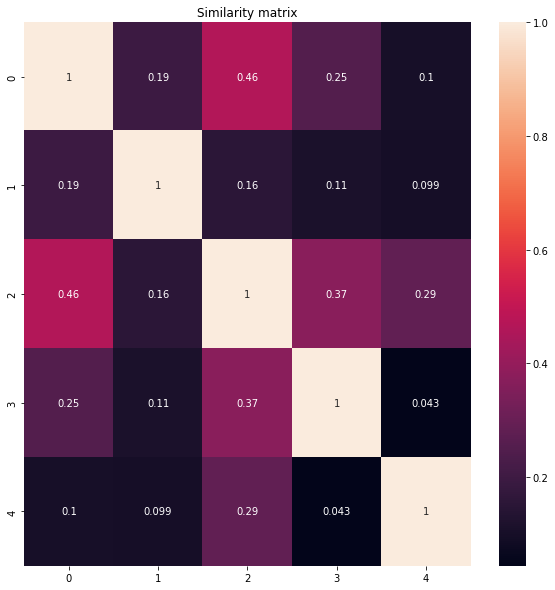

In [ ]:
for i in range(5):
  print(df["Keywords"][:5][i])

plot_similarity_matrix(matrix)

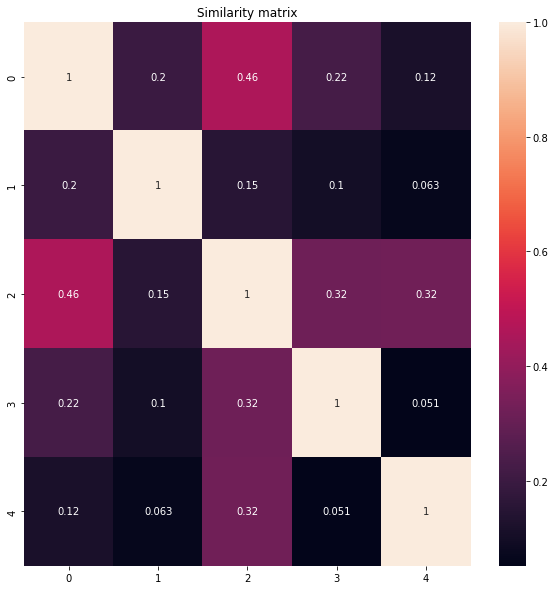

In [ ]:
skb, _= Similarity_keywords_bert(df["Keywords"][:5],5,1)
plot_similarity_matrix(skb)

# KeyBert

As all the texts are not associated with their keywords, we manage to extract them using the simplest method which is **`KeyBert`**.

In [ ]:
print(f'The number of texts without keywords is {len(df2["Keywords"][df2["Keywords"]=="Keywords"])}') 

In [ ]:
!pip install keybert
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT

In [ ]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')
kw_model_bert = KeyBERT(model=sbert_model) # the default model is distilbert, the used bert model showed better result

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
doc = df["Texts"][0]
doc[:1000]

'animal attacks are violent often fatal attacks caused by animals against humans one of the most common being bites bites are wounds caused as result of an animal or human attack these attacks are cause of human injuries and fatalities worldwide according to the pet ownership demographics sourcebook of united states citizens owned pet in the united states in approximately million people were bitten by dogs the frequency of animal attacks varies with geographical location as well as hormonal secretion gonad glands found on the anterior side of the pituitary gland secrete androgens and estrogens hormones animals with high levels of these hormones tend to be more aggressive which leads to higher frequency of attacks not only to humans but among themselves in the united states person is more likely to be killed by domesticated dog than they are to die from being hit by lightning according to the national safety council animal attacks have been identified as major public health problem in i

In [ ]:
key = kw_model_bert.extract_keywords(doc[:1000], keyphrase_ngram_range=(1, 2), nr_candidates=15, top_n=10,stop_words='english')
key

[('animal attacks', 0.7381),
 ('attacks humans', 0.5939),
 ('bitten dogs', 0.5875),
 ('attacks violent', 0.4933),
 ('people bitten', 0.4907),
 ('attacks caused', 0.473),
 ('attacks cause', 0.467),
 ('human attack', 0.4622),
 ('common bites', 0.4523),
 ('attacks varies', 0.4506)]

In [ ]:
given_keywords = ['violent','bites','aggressive','attack','public health','predation','hunt'] # This is the given keywords(500 texts with their keywords)

In [ ]:
# Pick the extracted keywords and mesure the similarity between the given keywords.
key_words = list(dict(key).keys()) # Same as [item[0] for item in key]
Embed = sbert_model.encode([" ".join(key_words)," ".join(given_keywords), doc],convert_to_numpy=True)
cos = cosine_similarity(Embed)

print(f'The similarity between the given keywords and the new ones is: {cos[0][1]}')
print(f'The similarity between the text and its the old keywords is : {cos[1][2]}')
print(f'The similarity between the text and its the new keywords is : {cos[0][2]}')

The similarity between the given keywords and the new ones is: 0.7749029397964478
The similarity between the text and its the old keywords is : 0.7558715343475342
The similarity between the text and its the new keywords is : 0.8302064538002014


In [ ]:
def keywords_extraction(old_df):
  """
  Input: the original dataFrame with the missing keywords
  Output: the new dataframe containing the missing keywords
  """
  
      # The most important part of each text, which is "the topic", is at the beginning of each text,
      # so we took the first 1000 items of each text, which gave a good result while testing it (similarity higher than 0.8).
      # "Note: This measure also aims to reduce resource consumption and execution time."

  df = old_df.copy()
  kw_model_bert = KeyBERT(model=sbert_model)

  for i in range(len(df["Keywords"])):
    if df["Keywords"][i]=="Keywords":
      key = kw_model_bert.extract_keywords(df["Texts"][i][:1000], keyphrase_ngram_range=(1, 2), nr_candidates=15, top_n=10)
      keywords = [item[0] for item in key]
      df["Keywords"][i]= str(keywords)

  return df


**Problem solved !**

In [ ]:
df_new = keywords_extraction(df) # It takes about 10 minutes to complete the execution
print(f'The number of texts without keywords is {len(df_new["Keywords"][df_new["Keywords"]=="Keywords"])}') 

# Unsupervised Classification using BERTopic algorithm

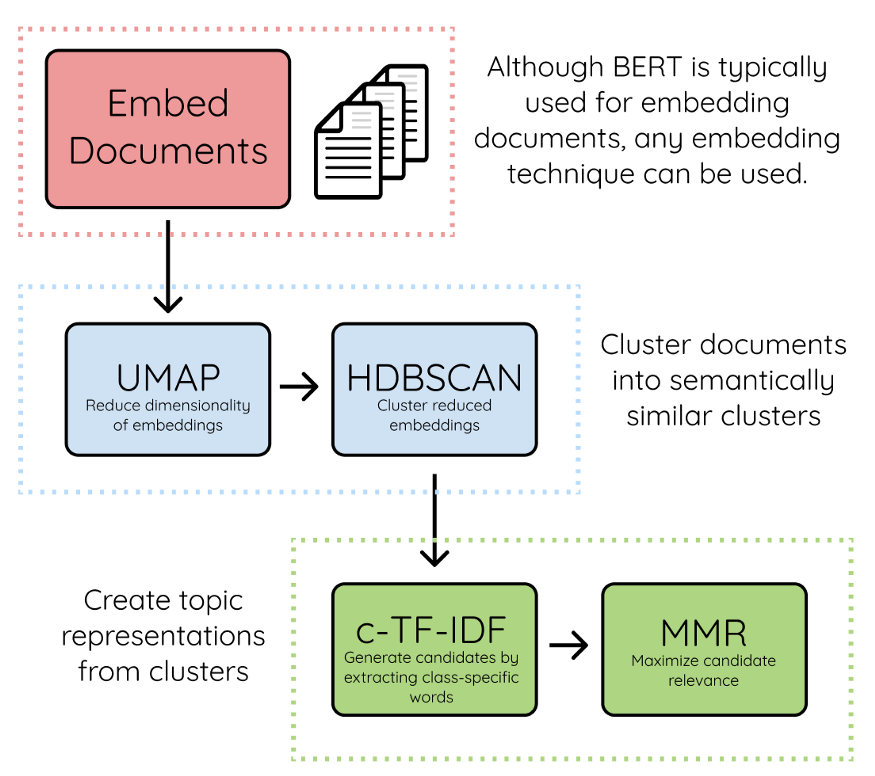

In [ ]:
#!pip install bertopic
from bertopic import BERTopic
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('all-mpnet-base-v2')

## Clusterer with HDBSCAN algorithm

### Clustrer with Keywords using HDBSCAN

In [ ]:
topic_model_keys = BERTopic(embedding_model=sbert_model, language="english", 
                             calculate_probabilities=False, 
                             min_topic_size=17,nr_topics=30,
                             n_gram_range = (1,2),
                             verbose=True)
topics_keys, _ = topic_model_keys.fit_transform(df["Keywords"])

In [ ]:
info2 = topic_model_keys.get_topic_info()
info2

,Topic,Count,Name
0,1,555,1_health_language_communication_of
1,0,29,0_music_film_band_album


In [ ]:
topics_per_class2 = topic_model_keys.topics_per_class(df["Keywords"], topics_keys, classes=df["Categories"].tolist())
fig_supervised2 = topic_model_keys.visualize_topics_per_class(topics_per_class2,top_n_topics=10)
fig_supervised2

30it [00:00, 56.70it/s]


###Clustrer with texts using HDBSCAN

In [ ]:
topic_model_hdbscan = BERTopic(embedding_model=sbert_model, language="english", 
                             calculate_probabilities=False, 
                             min_topic_size=17, 
                             n_gram_range = (1,2),
                             verbose=True)
topics_texts, _ = topic_model_hdbscan.fit_transform(df["Cleaned Texts"])

In [ ]:
info = topic_model_hdbscan.get_topic_info()
info

,Topic,Count,Name
0,0,94,0_war_state_tunisia_force
1,-1,81,-1_language_brand_marketing_earthquake
2,1,61,1_web_user_social_medium
3,2,57,2_engineering_school_engineer_vehicle
4,3,48,3_health_medicine_exercise_medical
5,4,44,4_robot_learning_ai_machine
6,5,37,5_music_metal_album_musical
7,6,31,6_animal_flood_water_area
8,7,30,7_family_child_parent_relationship
9,8,23,8_fiction_science_science fiction_series


In [ ]:
topic_model_hdbscan.visualize_topics()

In [ ]:
topics_per_class = topic_model_hdbscan.topics_per_class(df["Texts"], topics_texts, classes=df["Categories"].tolist())
fig_supervised = topic_model_hdbscan.visualize_topics_per_class(topics_per_class, top_n_topics=10)
fig_supervised

30it [00:32,  1.09s/it]


## Clusterer with K-means

In [ ]:
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=30)
topic_model_kmeans = BERTopic(hdbscan_model=cluster_model,
                            embedding_model=sbert_model, language="english", 
                             calculate_probabilities=False, 
                             min_topic_size=17, 
                             n_gram_range = (1,2),
                             verbose=True)
topics_sum, _ = topic_model_kmeans.fit_transform(df["Cleaned Texts"])

In [ ]:
info1 = topic_model_kmeans.get_topic_info()
info1.tail()

,Topic,Count,Name
25,25,14,25_health_diabetes_disease_public health
26,26,12,26_school_education_business_business school
27,27,12,27_crime_sexual_hate_discrimination
28,28,8,28_dance_dragon_sport_competition
29,29,7,29_iran_nuclear_weapon_nuclear weapon


In [ ]:
topic_model_kmeans.visualize_topics()

In [ ]:
topics_per_class1 = topic_model_kmeans.topics_per_class(df["Texts"], topics_sum, classes=df["Categories"].tolist())
fig_supervised1 = topic_model_kmeans.visualize_topics_per_class(topics_per_class1,top_n_topics=10)
fig_supervised1

30it [00:36,  1.22s/it]


In [ ]:
topic_model_kmeans.get_topic(1)

[('music', 0.03376309938914145),
 ('metal', 0.029973455418198527),
 ('album', 0.019845464887720807),
 ('musical', 0.01906141949345417),
 ('song', 0.018706157485000846),
 ('band', 0.018541860275634793),
 ('black', 0.015975936835805022),
 ('hop', 0.015600723904747761),
 ('hip', 0.015059896121926984),
 ('hip hop', 0.015013832578535304)]

# Text Summarization 

In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization") 

In [ ]:
text = " ".join(df["Texts"][1].split()[:600])
result = summarizer(text, min_length=60, max_length=70, do_sample=False)
summary = result[0]["summary_text"]
print(f'The length of the summarized text is {len(summary.split())} \n')

The length of the summarized text is 62 



The summary focuses primarily on the **first part** of the text, so we can see a significant similarity with this one compared to the full text.

From my point of view, I think that for each text, **the topic** is mainly presented in the first part.


In [ ]:
vectors = sbert_model.encode([summary,text,text[:1000]], convert_to_numpy=True)  
sim_vector = cosine_similarity(vectors,vectors)
print(f' Similarity between the summary and the full text {sim_vector[0][1]}')
print(f' Similarity between the summary and the first part of the text {sim_vector[0][2]}')

 Similarity between the summary and the full text 0.6378721594810486
 Similarity between the summary and the first part of the text 0.8806988596916199


In [ ]:
# this function takes more than 2hours for each text with 600 tokens (note: tested with more than 800 tokens but it didn't work 
#so we have to change the max length of the model which is 1024 tokens (based on it's vocablary))

def text_summarization(texts=df["Texts"]):
  """
  Input: The List of all texts in our dataframe
  Output: The list of summarized texts
  """
  summarized_texts = []
  #summarizer = pipeline("summarization")
  texts = texts.tolist()
  # summarizes each text in texts list
  summarized_texts = [summarizer( " ".join(text.split()[:600]) , min_length=60, max_length=70, do_sample=False)[0]["summary_text"]  for text in texts]    
    
    
  return summarized_texts

# Creat a new columns in df for the summaries
df["Summarized Texts"] = text_summarization()

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


In [ ]:
# delete the extra white space
df["Summarized Texts"] = df["Summarized Texts"].apply(lambda x : x.replace(" .","")) # eliminate the point at the end of each summary
df.to_csv("gdrive/My Drive/Colab Notebooks/new_datafile.csv")

# Text Augmentation 
*   Using the text summarization and Keybert techniques to generate additional samples.

* At least **10 new samples** are generated for each item in the original data set.

In [ ]:
!pip install textattack
!pip install tensorflow_text

In [ ]:
#import contractions
#from autocorrect import Speller
from tqdm import tqdm
from textattack.augmentation import EasyDataAugmenter

In [ ]:
def augmented_corpus(df=df):
  """
  Input: a dataframe that contains the texts and the keywords that we want to augment
  Ouput: lists of the augmented texts and keywords with the titles and categories 
  """
  categories,titles,texts,keywords = [],[],[],[] 
  n=0
  m=0
 # initialize the augmentation model that can generate up to 15 samples
  aug = EasyDataAugmenter(pct_words_to_swap=0.25, 
                        transformations_per_example=15)
  # Clean the list of keywords (which has been considered as a type of str with the brackets ect...)
  df["Keywords"] = df["Keywords"].apply(lambda x: re.sub('[^A-Za-z]'," ",str(x)).strip())

  for i in tqdm(range(len(df))):
    
      aug_text,aug_keys = [], []
      aug_text = aug.augment(df["Summarized Texts"][i])
      #Extract new keywords then do the augmentation
      key = kw_model_bert.extract_keywords(df["Texts"][i][:1000], keyphrase_ngram_range=(1, 2), nr_candidates=15, top_n=10,stop_words='english')
      keys = [item[0] for item in key]
      new_keys = " ".join(keys)
      aug_keys = aug.augment(new_keys)
      
      n = len(aug_text)
      m=len(aug_keys)
      print(" The lengths n=",n,"and m=",m)

      texts.extend(aug_text)
      keywords.extend(aug_keys)
      

      if n>m : # if the list of texts larger than the lis of keywords then we should add n-m items to keywords
        k = n-m
        add_items = aug.augment(aug_keys[m-1]) # generate more items to add to keywords list
        keywords.extend(add_items[:k])
        categories.extend([df["Categories"][i]]*n) # if n=0 (in case of passing), there is no list to be added
        titles.extend([df['Titles'][i]]*n)

      elif n<m:
        k= m-n
        add_items = aug.augment(aug_text[n-1]) # generate more items to add to text list
        texts.extend(add_items[:k])
        categories.extend([df["Categories"][i]]*m) # if n=0 (in case of passing), there is no list to be added
        titles.extend([df['Titles'][i]]*m)
        
      else:
        categories.extend([df["Categories"][i]]*n) # if n=0 (in case of passing), there is no list to be added
        titles.extend([df['Titles'][i]]*n)

    

  return categories,titles,texts,keywords

categories,titles,texts,keywords = augmented_corpus()

In [ ]:
print(len(categories),len(titles),len(texts),len(keywords))

7008 7008 7008 7008


In [ ]:
old_df = df[['Categories','Titles','Texts','Keywords']]
new_df1 = pd.DataFrame({"Categories":categories,"Titles":titles,"Texts":texts,"Keywords":keywords})
new_df = pd.concat([[old_df,new_df1]])
len(new_df)

7592

In [ ]:
new_df.to_csv("gdrive/My Drive/Colab Notebooks/augmented_datafile.csv")

# Supervised Text Classification 

## Building the models

### Data Preparation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Encode the categories labels to numerical arguments
lb = LabelEncoder()
lb.fit(df['Categories'])
old_df['Target'] = lb.transform(old_df['Categories'])
df['Target'] = lb.transform(df['Categories'])
num_classes =  len(lb.classes_)

#lb.inverse_transform(df['Target']) get the label assigned to each number

In [ ]:
# Process the list of keywords (which has been considered as a type of str)
df["Keywords"] = df["Keywords"].apply(lambda x: re.sub('[^A-Za-z]'," ",str(x)).strip())
old_df["Keywords"] = old_df["Keywords"].apply(lambda x: re.sub('[^A-Za-z]'," ",str(x)).strip())


# Splitting the data
Y = tf.keras.utils.to_categorical(df["Target"].values, num_classes=num_classes)
old_Y = tf.keras.utils.to_categorical(old_df["Target"].values, num_classes=num_classes)


def split_data(df,data,Y):
  return train_test_split(df[data], Y, test_size=0.2, random_state=110, stratify = Y)

X_train_old, X_test_old, Y_train_old, Y_test_old = split_data(old_df,'Texts',old_Y)
X_train, X_test, Y_train, Y_test = split_data(df,'Texts',Y)

x_train_old, x_test_old, y_train_old, y_test_old = split_data(old_df,'Keywords',old_Y)
x_train, x_test, y_train, y_test = split_data(df,'Keywords',Y)

In [ ]:
x_test.shape,y_test.shape

((1519,), (1519, 30))

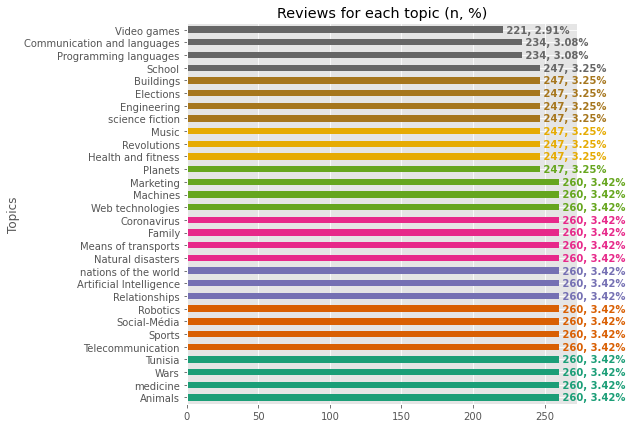

In [ ]:
# Observe the data if it's inbalanced of not
def plot_categories():
  plt.style.use('ggplot')
  num_classes = len(lb.classes_)
  colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
  iter_color = iter(colors)

  df["Categories"].value_counts().plot.barh(title="Reviews for each topic (n, %)", ylabel="Topics", color=colors, figsize=(7,7))

  for i, v in enumerate(df["Categories"].value_counts()):
    c = next(iter_color)
    plt.text(v, i,
            " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%", 
            color=c, 
            va='center', 
            fontweight='bold')
    
plot_categories()    

In [ ]:
# Function aims to plot the accuracy of the model and it's evaluation on the test set
def plot_graphs(model, metric,title):
  plt.plot(model.history.history[metric],marker='o', markersize=4) # plots the metric used on train set
  plt.plot(model.history.history['val_'+metric], '',marker='x', markersize=5) # plots the metric used on test set
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.title(title,fontsize=10)
  plt.legend([metric, 'val_'+metric],loc='lower right',fontsize=10)
  plt.show()

### Building the models

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
!pip install  tensorflow_text
import tensorflow_text as text

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM,Dropout

     |████████████████████████████████| 4.9 MB 4.3 MB/s 
     |████████████████████████████████| 462 kB 55.0 MB/s 


#### LSTM model


In [ ]:
def LSTM_model(MAX_NB_WORDS, EMBEDDING_DIM,X):
  
  model = Sequential()
  model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM,  input_length=X.shape[1]))
  model.add(Dropout(0.2,name='dropout'))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(30, activation='softmax'))
  
  METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall')]


  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy() ,
              metrics=METRICS)
  return model

#### Bert models

In [ ]:

def build_model():
  # Bert layers
  bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessing")
  bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",trainable=True,name="Bert_encoder")

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input text')
  preprocessed_text = bert_preprocess(text_input)
  outputs = bert_encoder(preprocessed_text)

  # Neural network layers
  L = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
  L = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(L)

  # Use inputs and outputs to construct a final model
  model = tf.keras.Model(inputs=[text_input], outputs = [L])

  METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall')]


  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy() ,
              metrics=METRICS)

  return model

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)



In [ ]:
def build_model_combination():
  # Bert layers
  bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessing")
  bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",trainable=True,name="Bert_encoder")

  # Neural network layers for texts classification
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input_text')
  preprocessed_text = bert_preprocess(text_input)
  outputs_texts = bert_encoder(preprocessed_text)
  T = tf.keras.layers.Dropout(0.2, name="dropout_texts")(outputs_texts['pooled_output'])
  T = tf.keras.layers.Dense(num_classes, activation='softmax', name="output_texts")(T)


  # Neural network layers for keywords classification
  keywords_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input_keywords')
  preprocessed_keys = bert_preprocess(keywords_input)
  outputs_keys = bert_encoder(preprocessed_keys)
  K = tf.keras.layers.Dropout(0.2, name="dropout_keywords")(outputs_keys['pooled_output'])
  K = tf.keras.layers.Dense(num_classes, activation='softmax', name="output_keywords")(K)

  # Use inputs and outputs to construct a final model
  Average = tf.keras.layers.Average(name="Average_Layer")([T, K])
  model = tf.keras.Model(inputs=[text_input,keywords_input], outputs = [Average])

  METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall')]


  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy() ,
              metrics=METRICS)

  return model

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

##Classification without data augmentation

### Testing LSTM Model on texts

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Texts'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 62715 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['Texts'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (7592, 500)


In [ ]:
#Y = pd.get_dummies(df['Categories']).values
Y = tf.keras.utils.to_categorical(df["Target"].values, num_classes=num_classes)
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (7592, 30)


In [ ]:
X_train_old, X_test_old, Y_train_old, Y_test_old = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train_old.shape,Y_train_old.shape)
print(X_test_old.shape,Y_test_old.shape)

(6832, 500) (6832, 30)
(760, 500) (760, 30)


In [ ]:
text_old_model = LSTM_model(MAX_NB_WORDS, EMBEDDING_DIM,X)

text_old_model.fit(X_train_old, Y_train_old,epochs=10,
           validation_data=(X_test_old,Y_test_old))

Epoch 1/10
214/214 [==============================] - 806s 4s/step - loss: 3.3995 - accuracy: 0.0476 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 3.3975 - val_accuracy: 0.0763 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
 24/214 [==>...........................] - ETA: 11:19 - loss: 3.3956 - accuracy: 0.0664 - Precision: 0.0000e+00 - Recall: 0.0000e+00

In [ ]:
plt.title('Accuracy')
plt.plot(text_old_model.history.history['accuracy'], label='train accuracy')
plt.plot(text_old_model.history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show();

### Classification using Texts 

In [ ]:
#text_old_model = build_model()
#tf.keras.utils.plot_model(model=text_old_model, show_shapes=True, dpi=100)

In [ ]:
text_old_model = build_model()

text_old_model.fit(X_train_old, Y_train_old, 
           epochs=10,
           validation_data=(X_test_old,Y_test_old))

Epoch 1/10
15/15 [==============================] - 56s 2s/step - loss: 3.5719 - accuracy: 0.0514 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 3.2754 - val_accuracy: 0.0940 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
15/15 [==============================] - 37s 3s/step - loss: 3.1263 - accuracy: 0.1049 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 2.9844 - val_accuracy: 0.1538 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/10
15/15 [==============================] - 37s 2s/step - loss: 2.8185 - accuracy: 0.2548 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 2.6558 - val_accuracy: 0.3248 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 4/10
15/15 [==============================] - 34s 2s/step - loss: 2.3354 - accuracy: 0.4582 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 2.2013 - val_accuracy: 0.5043 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 5/10
15/15 [==============================

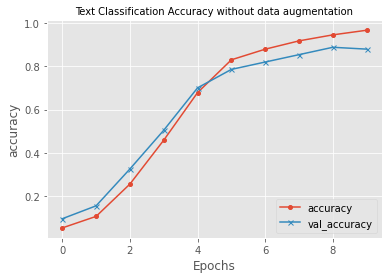

In [ ]:
plot_graphs(text_old_model, 'accuracy','Text Classification Accuracy without data augmentation')

In [ ]:
#text_old_model.save('gdrive/My Drive/Colab Notebooks/text_old_model.h5')
text_old_model = tf.keras.models.load_model(('gdrive/My Drive/Colab Notebooks/text_old_model.h5'),custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
# Calculating the F1_score
y_pred = np.argmax(text_old_model(X_test_old),axis=1)
y_true = np.argmax(Y_test_old,axis=1)
#print(classification_report(y_true, y_pred, target_names=lb.classes_))
print("The F1_score is: ",f1_score(y_true, y_pred, average='weighted') ) # average = 'weighted' used in imbalanced data 

The F1_score is:  0.8584723918057252


###Classification using keywords

In [ ]:
keywords_old_model = build_model()
keywords_old_model.fit(x_train_old, y_train_old, 
           epochs=10,
           validation_data=(x_test_old,y_test_old))

Epoch 1/10
15/15 [==============================] - 46s 2s/step - loss: 3.5432 - accuracy: 0.0471 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 3.3489 - val_accuracy: 0.0684 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
15/15 [==============================] - 26s 2s/step - loss: 3.1923 - accuracy: 0.1006 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 3.1081 - val_accuracy: 0.1795 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/10
15/15 [==============================] - 26s 2s/step - loss: 2.8983 - accuracy: 0.2313 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 2.7459 - val_accuracy: 0.3162 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 4/10
15/15 [==============================] - 26s 2s/step - loss: 2.5295 - accuracy: 0.3919 - Precision: 1.0000 - Recall: 0.0021 - val_loss: 2.4489 - val_accuracy: 0.4615 - val_Precision: 1.0000 - val_Recall: 0.0085
Epoch 5/10
15/15 [==============================] - 26s 2s/step 

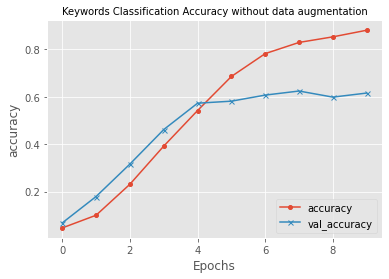

In [ ]:
plot_graphs(keywords_old_model, 'accuracy','Keywords Classification Accuracy without data augmentation') 

In [ ]:
#keywords_old_model.save('gdrive/My Drive/Colab Notebooks/keywords_old_model.h5')
keywords_old_model = tf.keras.models.load_model('gdrive/My Drive/Colab Notebooks/keywords_old_model.h5',custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
# Calculating the F1_score
y_pred = np.argmax(keywords_old_model(X_test_old),axis=1)
y_true = np.argmax(Y_test_old,axis=1)
#print(classification_report(y_true, y_pred, target_names=lb.classes_))
print("The F1_score is: ",f1_score(y_true, y_pred, average='weighted') ) # average = 'weighted' used in imbalanced data 

The F1_score is:  0.5417094776069135


###Final Model with combinaision

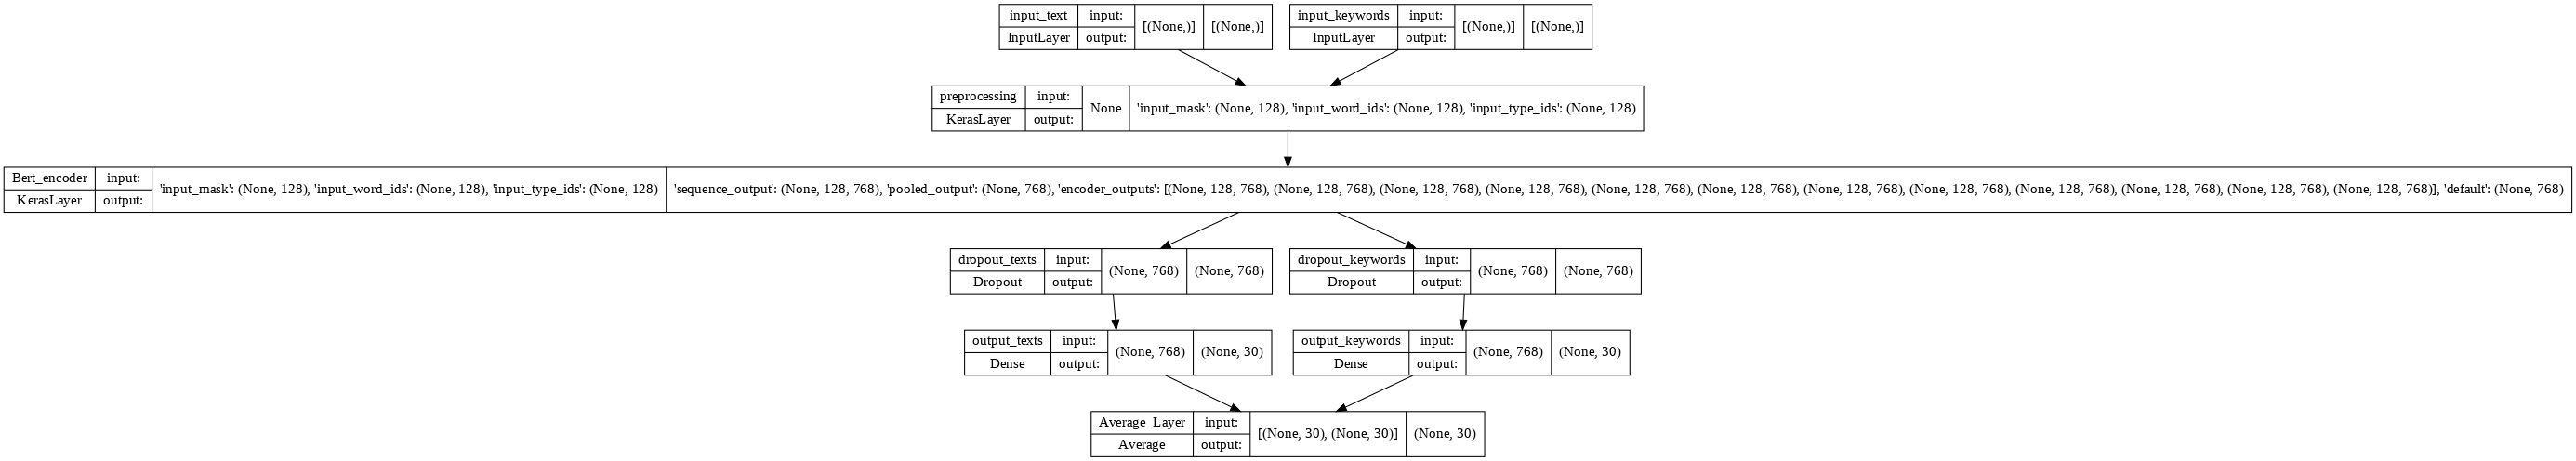

In [ ]:
final_old_model = build_model_combination()

tf.keras.utils.plot_model(model=final_old_model, show_shapes=True, dpi=76)

In [ ]:
final_old_model = build_model_combination()

# The training took more than 1hour
final_old_model.fit([X_train_old,x_train_old], Y_train_old, 
           epochs=10,
           batch_size=10,
           validation_data=([X_test_old,x_test_old],Y_test_old))

Epoch 1/10
47/47 [==============================] - 49s 643ms/step - loss: 3.4829 - accuracy: 0.0278 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 3.3446 - val_accuracy: 0.0684 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
47/47 [==============================] - 29s 620ms/step - loss: 3.0651 - accuracy: 0.2034 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 2.6281 - val_accuracy: 0.3846 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/10
47/47 [==============================] - 29s 616ms/step - loss: 2.2233 - accuracy: 0.5910 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 1.8296 - val_accuracy: 0.7436 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 4/10
47/47 [==============================] - 29s 614ms/step - loss: 1.4879 - accuracy: 0.8287 - Precision: 1.0000 - Recall: 0.0236 - val_loss: 1.3766 - val_accuracy: 0.8205 - val_Precision: 0.8333 - val_Recall: 0.0427
Epoch 5/10
47/47 [==============================] - 

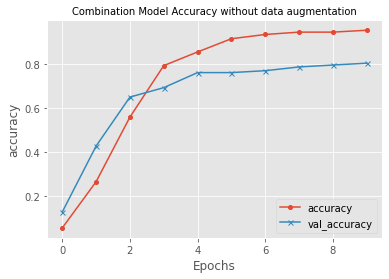

In [ ]:
plot_graphs(final_old_model,'accuracy','Combination Model Accuracy without data augmentation')

In [ ]:
final_old_model.save('gdrive/My Drive/Colab Notebooks/final_old_model.h5')
#final_old_model = tf.keras.models.load_model('gdrive/My Drive/Colab Notebooks/final_old_model.h5',custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
# Calculating the F1_score
y_pred = np.argmax(final_old_model([X_test_old,x_test_old]),axis=1)
y_true = np.argmax(Y_test_old,axis=1)
#print(classification_report(y_true, y_pred, target_names=lb.classes_))
print("The F1_score is: ",f1_score(y_true, y_pred, average='weighted') ) # average = 'weighted' used in imbalanced data 

The F1_score is:  0.851030451030451


## Classification using data augmentation

### Classification using Texts 


In [ ]:
text_model = build_model()

text_model.fit(X_train, Y_train, 
           epochs=10,
           validation_data=(X_test,Y_test))

Epoch 1/10
190/190 [==============================] - 194s 955ms/step - loss: 1.6202 - accuracy: 0.6340 - Precision: 0.9724 - Recall: 0.3540 - val_loss: 0.2400 - val_accuracy: 0.9618 - val_Precision: 0.9758 - val_Recall: 0.9282
Epoch 2/10
190/190 [==============================] - 180s 949ms/step - loss: 0.1637 - accuracy: 0.9676 - Precision: 0.9762 - Recall: 0.9541 - val_loss: 0.0635 - val_accuracy: 0.9868 - val_Precision: 0.9875 - val_Recall: 0.9855
Epoch 3/10
190/190 [==============================] - 180s 950ms/step - loss: 0.0644 - accuracy: 0.9835 - Precision: 0.9848 - Recall: 0.9821 - val_loss: 0.0395 - val_accuracy: 0.9875 - val_Precision: 0.9875 - val_Recall: 0.9875
Epoch 4/10
190/190 [==============================] - 180s 949ms/step - loss: 0.0463 - accuracy: 0.9849 - Precision: 0.9852 - Recall: 0.9845 - val_loss: 0.0410 - val_accuracy: 0.9842 - val_Precision: 0.9842 - val_Recall: 0.9835
Epoch 5/10
190/190 [==============================] - 180s 949ms/step - loss: 0.0364 - a

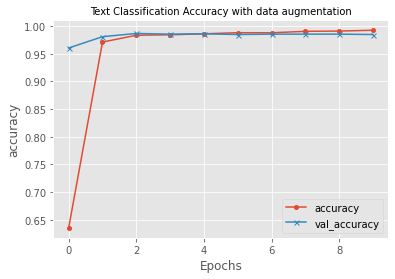

In [ ]:
plot_graphs(text_model, 'accuracy','Text Classification Accuracy with data augmentation')

In [ ]:
#text_model.save('gdrive/My Drive/Colab Notebooks/text_model.h5') 
text_model = tf.keras.models.load_model('gdrive/My Drive/Colab Notebooks/text_model.h5',custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
# Calculating the F1_score
y_pred = np.argmax(text_model.predict(X_test),axis=1)
y_true = np.argmax(Y_test,axis=1)
#print(classification_report(y_true, y_pred, target_names=lb.classes_))
print("The F1_score is: ",f1_score(y_true, y_pred, average='weighted') ) # average = 'weighted' used in imbalanced data 

The F1_score is:  0.9861703372103412


In [ ]:
txt = text_cleaning("Marketing is the activity, set of institutions, and processes for creating, communicating, delivering, and exchanging offerings that have value for customers, clients, partners, and society at large.")

lb.inverse_transform(np.argmax(text_model.predict([txt])).reshape(1)) # Get the class name

array(['Marketing'], dtype=object)

###Classification using keywords

In [ ]:
keywords_model = build_model()

keywords_model.fit(x_train, y_train, 
           epochs=10,
           validation_data=(x_test,y_test))

Epoch 1/10
190/190 [==============================] - 365s 2s/step - loss: 1.5852 - accuracy: 0.6532 - Precision: 0.9679 - Recall: 0.3425 - val_loss: 0.3034 - val_accuracy: 0.9375 - val_Precision: 0.9610 - val_Recall: 0.9092
Epoch 2/10
190/190 [==============================] - 344s 2s/step - loss: 0.2190 - accuracy: 0.9564 - Precision: 0.9705 - Recall: 0.9359 - val_loss: 0.1294 - val_accuracy: 0.9671 - val_Precision: 0.9728 - val_Recall: 0.9638
Epoch 3/10
190/190 [==============================] - 343s 2s/step - loss: 0.1000 - accuracy: 0.9768 - Precision: 0.9814 - Recall: 0.9717 - val_loss: 0.1134 - val_accuracy: 0.9658 - val_Precision: 0.9741 - val_Recall: 0.9651
Epoch 4/10
190/190 [==============================] - 344s 2s/step - loss: 0.0667 - accuracy: 0.9789 - Precision: 0.9818 - Recall: 0.9776 - val_loss: 0.1191 - val_accuracy: 0.9691 - val_Precision: 0.9741 - val_Recall: 0.9658
Epoch 5/10
190/190 [==============================] - 344s 2s/step - loss: 0.0465 - accuracy: 0.9827

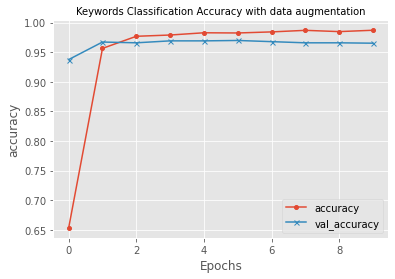

In [ ]:
plot_graphs(keywords_model, 'accuracy','Keywords Classification Accuracy with data augmentation') 

In [ ]:
#keywords_model.save('gdrive/My Drive/Colab Notebooks/keywords_model.h5')
keywords_model = tf.keras.models.load_model(('gdrive/My Drive/Colab Notebooks/keywords_model.h5'),custom_objects={'KerasLayer': hub.KerasLayer}) 

In [ ]:
# Calculating the F1_score
y_pred = np.argmax(keywords_model.predict(x_test),axis=1)
y_true = np.argmax(y_test,axis=1)
#print(classification_report(y_true, y_pred, target_names=lb.classes_))
print("The F1_score is: ",f1_score(y_true, y_pred, average='weighted') ) # average = 'weighted' used in imbalanced data 

The F1_score is:  0.9927627890031271


###Final Model with combinaision

In [ ]:
# The training took more than 2hours
final_model = build_model_combination()

final_model.fit([X_train,x_train], Y_train, 
           epochs=10,
           batch_size=10,
           validation_data=([X_test,x_test],Y_test))

Epoch 1/10
608/608 [==============================] - 798s 1s/step - loss: 1.1656 - accuracy: 0.7766 - Precision: 0.9744 - Recall: 0.4380 - val_loss: 0.2041 - val_accuracy: 0.9598 - val_Precision: 0.9778 - val_Recall: 0.8999
Epoch 2/10
608/608 [==============================] - 744s 1s/step - loss: 0.1354 - accuracy: 0.9766 - Precision: 0.9861 - Recall: 0.9356 - val_loss: 0.0835 - val_accuracy: 0.9789 - val_Precision: 0.9925 - val_Recall: 0.9598
Epoch 3/10
608/608 [==============================] - 757s 1s/step - loss: 0.0610 - accuracy: 0.9844 - Precision: 0.9926 - Recall: 0.9699 - val_loss: 0.0497 - val_accuracy: 0.9776 - val_Precision: 0.9952 - val_Recall: 0.9598
Epoch 4/10
608/608 [==============================] - 748s 1s/step - loss: 0.0356 - accuracy: 0.9867 - Precision: 0.9948 - Recall: 0.9725 - val_loss: 0.0477 - val_accuracy: 0.9803 - val_Precision: 0.9899 - val_Recall: 0.9638
Epoch 5/10
608/608 [==============================] - 743s 1s/step - loss: 0.0489 - accuracy: 0.9816

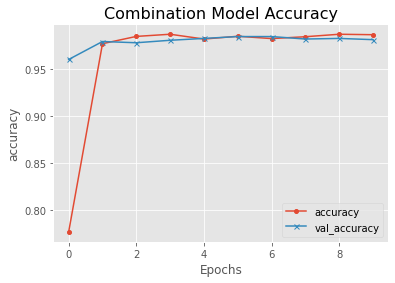

In [ ]:
plot_graphs(final_model,'accuracy','Combination Model Accuracy with data augmentation')

In [ ]:
#final_model.save('gdrive/My Drive/Colab Notebooks/final_model.h5')
final_model = tf.keras.models.load_model('gdrive/My Drive/Colab Notebooks/final_model.h5',custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
final_model.evaluate([X_test,x_test],Y_test)

In [ ]:
# Calculating the F1_score
y_pred = np.argmax(final_model.predict([X_test,x_test]),axis=1)
y_true = np.argmax(Y_test,axis=1)
#print(classification_report(y_true, y_pred, target_names=lb.classes_))
print("The F1_score is: ",f1_score(y_true, y_pred, average='weighted') ) # average = 'weighted' used in imbalanced data 

The F1_score is:  0.9920821955170059


In [ ]:
txt="""To do this, we used the "TextAttack" framework which is used for data augmentation and model training in the natural language domain to augment our textual data. [URL]
From each summary, the "EasyDataAugmenter" model can generate up to 12 additional texts by performing transformations on the original text 
such as rephrasing or replacing certain words with these synonyms.
"""

In [ ]:
key_txt = kw_model_bert.extract_keywords(txt, keyphrase_ngram_range=(1, 2), nr_candidates=15, top_n=10,stop_words='english')
k = str(list(dict(key_txt).keys()))

In [ ]:
prediction = final_model.predict([tf.convert_to_tensor([txt]) ,tf.convert_to_tensor([k]) ])

In [ ]:
np.any(prediction>0.6) # Tester si un des valeurs de classification est superieur à 0.5 (30 valeurs<=>30classes) 

False

In [ ]:
result = lb.inverse_transform(np.argmax(prediction).reshape(1)) # Get the class name
result[0] # That's why we need a threshold to detect if the topic belongs to our database or it's a new one

'School'

# Notebook Requirements

In [ ]:
import os 
!mkdir wiem

In [ ]:
!pip install pipreqs

In [ ]:
!pipreqs "/content/wiem/"

INFO: Successfully saved requirements file in /content/wiwi/requirements.txt
